<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance Course

**Module 2 &mdash; Backtesting**

[team@tpq.io](mailto:team@tpq.io) | [http://tpq.io](http://tpq.io)

The Python Quants GmbH

## Requirements

Make sure to have installed locally a **comprehensive Python installation** like the [Anaconda](http://repo.continuum.io) Python distribution.

Alternatively, and more easily, register on the **[Quant Platform](http://pqp.io)** where you can execute this Jupyter Notebook file in the browser. After registration, you find all Jupyter Notebook files of this course in the folder `pffcourse`.

## Necessary Imports

As you know by now, working with Python in general requires you to **import certain modules/packages** from the standard library or from the so-called scientific or PyData stack (i.e. from third parties).

In [ ]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline

## Retrieving Index Level Data

Remember from the first module how we retrieve **EOD price data**. For this module, we work again with Apple, Inc. stock prices.

In [ ]:
symbols = ['AAPL.O','MSFT.O','.SPX']
shorts = {'AAPL.O' : 124, #117,124
          'MSFT.O' : 120,
          '.SPX'   : 110}
longs = {'AAPL.O' : 125, #133,125
         'MSFT.O' : 234,
         '.SPX'   : 116}

data = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                   index_col=0, parse_dates=True)[symbols].dropna()
data = pd.DataFrame(data)

In [ ]:
data.tail()  # the final five rows

## Generating Trading Signals

We want to implement a **trading strategy based on simple moving averages (SMA)**. We work with two SMAs:

* short-term SMA over 42 days (SMA42)
* long-term SMA over 252 days (SMA252)

We distinguish two constellations:

* SMA42 > SMA252: buy signal, being **long** the market
* SMA42 < SMA252: sell signal, being **short** the market

We calculate the two SMAs as follows.

In [4]:
for symbol in symbols:
    data[symbol+'_SMA_short'] = data[symbol].rolling(window=shorts[symbol]).mean()
    data[symbol+'_SMA_long'] = data[symbol].rolling(window=longs[symbol]).mean()
data.dropna(inplace=True)  # drop rows with NaN values

In graphical terms, we want to be **long the market whenever the SMA42 line is above the SMA252 line** and vice versa.

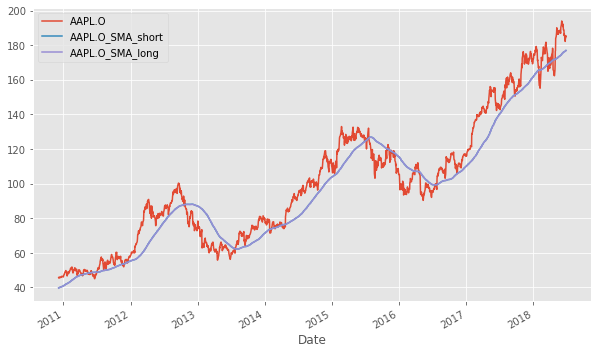

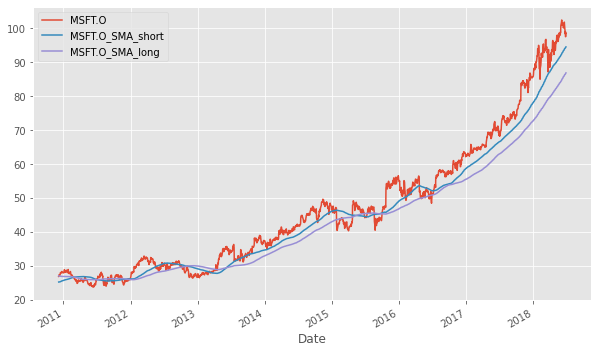

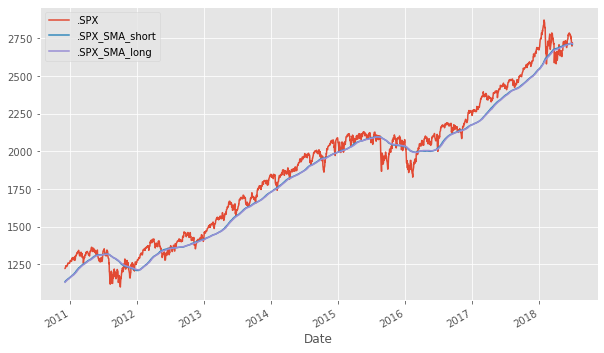

In [5]:
for symbol in symbols:
    data[[symbol, symbol+'_SMA_short', symbol+'_SMA_long']].plot(figsize=(10, 6));

This need to be formalized for the calculations to come. We represent **"being long the market" by 1** and **"being short the market" by -1**.

In [6]:
# vectorized evaluation of the trading condition/signal generation
for symbol in symbols:
    data[symbol+'_position'] = np.where(data[symbol+'_SMA_short'] > data[symbol+'_SMA_long'], 1, -1)

Let us **visualize the positions** resulting from the signal. We start with a long position, do several re-positionings and end with a short position.

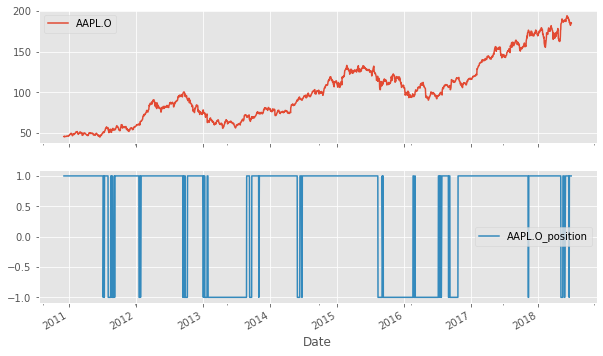

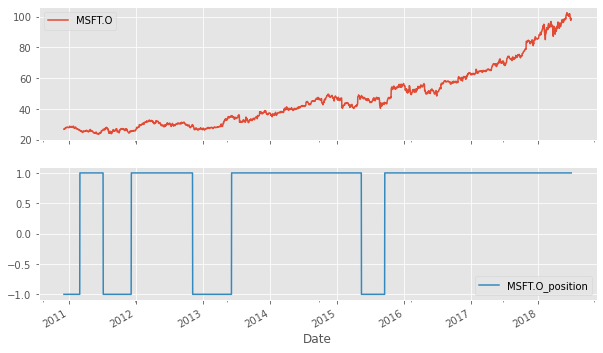

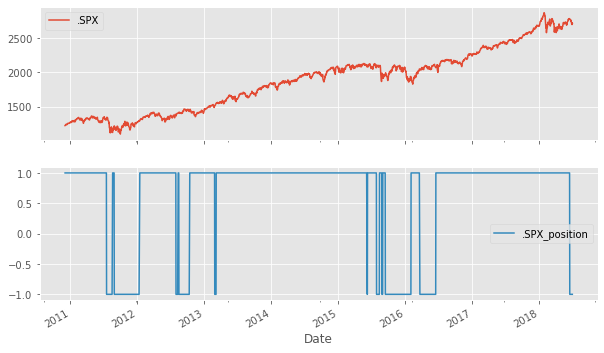

In [7]:
for symbol in symbols:
    data[[symbol, symbol+'_position']].plot(subplots=True, figsize=(10, 6))
    plt.ylim(-1.1, 1.1)  # adjust y-axis limits

## Backtesting = Judging Performance

Let us calculate the **log returns** as in the first module. These are needed to judge the performance, i.e. to backtest, our SMA-based trading strategy. We call the column `market` since these are the _market returns_.

In [8]:
# vectorized calculation of log returns
for symbol in symbols:
    data[symbol+'_market'] = np.log(data[symbol] / data[symbol].shift(1))

Next, we can use the market returns to derive the **strategy returns** in vectorized fashion. Note the shift of the `position` column by one day, i.e. we have entered/maintained a position yesterday and and today's returns. It now becomes clear, why 1 represents a long position and -1 a short position: we get the market return when we are long and -1 times the market return when we are short. All this makes obviously a number of simplifying assumptions (e.g. no transaction costs).

In [9]:
# vectorized calculation of strategy returns
for symbol in symbols:
    data[symbol+'_strategy'] = data[symbol+'_position'].shift(1) * data[symbol+'_market']

Next, let us calculate the **cumulative returns** of the market vs. the trading strategy. This is straightforward since we work with log returns. We first calculate the cumulative sums (`cumsum`) and the apply the exponential function (`np.exp`) to the respective time series.

In [10]:
for symbol in symbols:
    data[[symbol+'_market', symbol+'_strategy']].cumsum().apply(np.exp).tail()

And the **cumulative market vs. strategy returns** visualized. As the numbers and the plot suggest, the strategy in this case **outperforms** the market by a considerable margin.

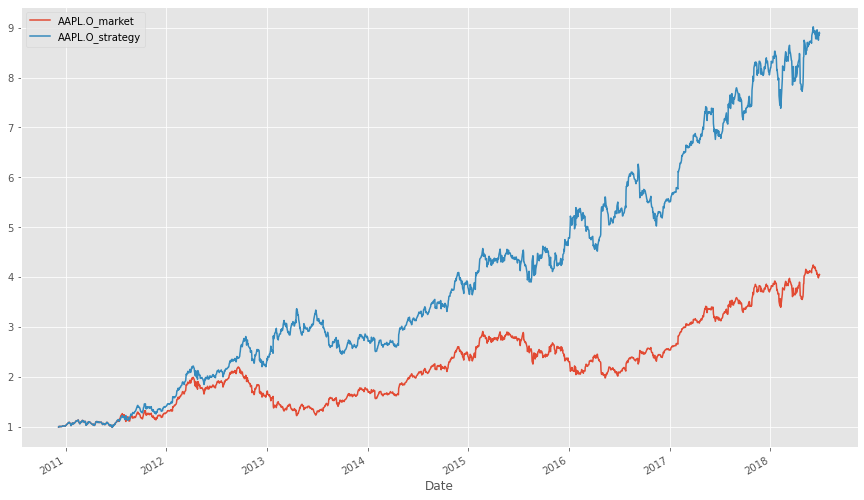

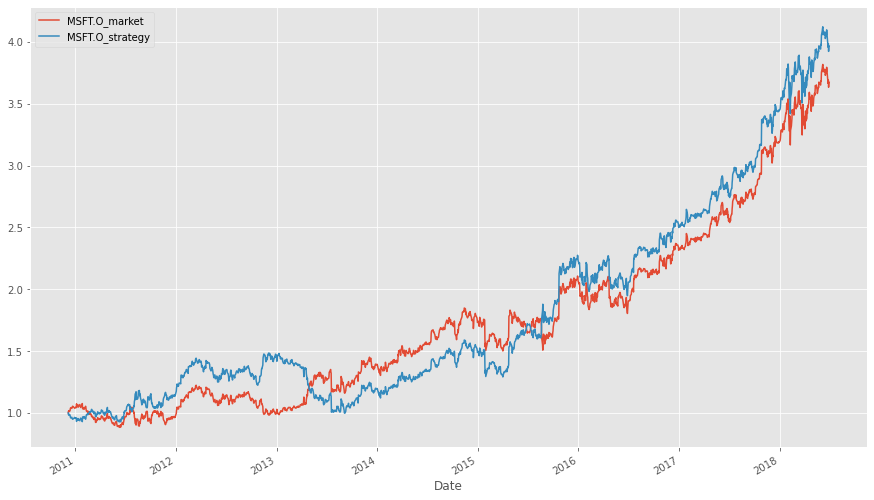

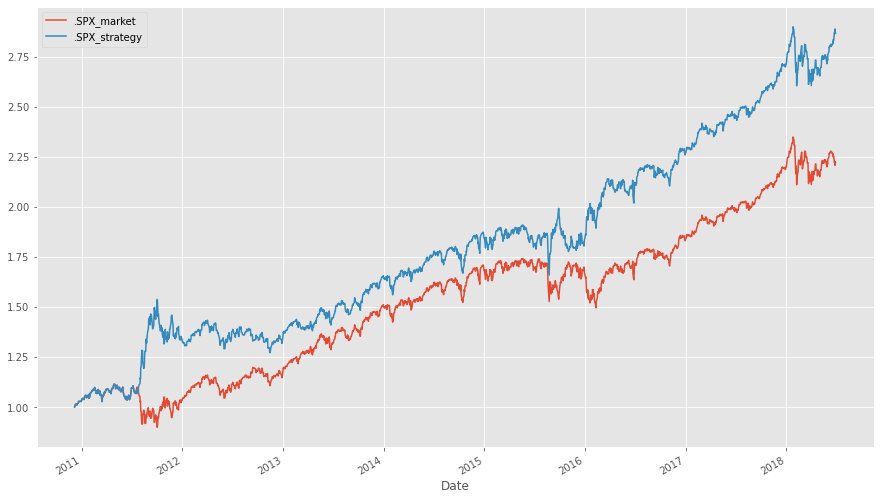

In [11]:
for symbol in symbols:
    data[[symbol+'_market', symbol+'_strategy']].cumsum().apply(np.exp).plot(figsize=(15, 9));

## Risk and Return

Final consideration: what about the relation between **risk & return**? Let us quickly do the math. The **annualized return** of the strategy is obviously higher that from the market ...

In [12]:
arets = []
for symbol in symbols:
    arets.append(data[[symbol+'_market', symbol+'_strategy']].mean() * 252)  # annualized returns
arets

[AAPL.O_market      0.185039
 AAPL.O_strategy    0.289201
 dtype: float64,
 MSFT.O_market      0.172228
 MSFT.O_strategy    0.182382
 dtype: float64,
 .SPX_market      0.105701
 .SPX_strategy    0.139450
 dtype: float64]

... while the **annualized volatility** is more or less the same. The higher returns do not lead to higher risk in this case.

In [13]:
astds = []
for symbol in symbols:
    astds.append(data[[symbol+'_market', symbol+'_strategy']].std() * 252 ** 0.5)  # annualized volatility
astds

[AAPL.O_market      0.249470
 AAPL.O_strategy    0.249076
 dtype: float64,
 MSFT.O_market      0.225581
 MSFT.O_strategy    0.225550
 dtype: float64,
 .SPX_market      0.143201
 .SPX_strategy    0.143086
 dtype: float64]

## Closing Remarks

This finishes the second module of the Python for Finance email course. In this module, you have learned:

* how to generate trading signals (market positionings) in vectorized fashion
* how to backtest a formalized strategy based on the market log returns in vectorized fashion
* how to calculate and visualize the cumulative returns of trading strategies
* how to calculate annualized returns and volatilities for trading strategies

These are fundamentally important concepts in systematic (algorithmic) trading.

## Exercises

In order to master the material of this module, do the following:

* replace the S&P 500 index by another symbol, eg. `MSFT.O` or `.SPX`
* work with different SMA values, e.g. 20 and 100
* implement an optimization procedure to come up with optimal SMA values
* implement a backtesting procedure which distinguishes in-sample (training) from out-of-sample (test) data sets
* formalize other trading strategies based on other metrics
* install a dedicated backtesting library like [PyAlgoTrade](http://gbeced.github.io/pyalgotrade/) or [zipline](https://github.com/quantopian/zipline) and do the tutorials

## References 

You find background information for the topics covered in this module in the following book:

* Hilpisch, Yves (2018): _Python for Finance_. 2nd ed., O'Reilly, chs. 6 & 15.

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

**Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance** |
<a href="http://python-for-finance.com" target="_blank">Python for Finance @ O'Reilly</a>

**Derivatives Analytics with Python** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>

**Listed Volatility and Variance Derivatives** |
<a href="http://lvvd.tpq.io" target="_blank">Listed VV Derivatives @ Wiley Finance</a>